<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

<a href="https://www.mayoclinic.org/"><img src="images/mayologo.png" alt="Mayo Logo"></a>
# Medical Image Classification Using the MedNIST Dataset
### Special thanks to <a href="https://www.mayo.edu/research/labs/radiology-informatics/overview">Dr. Bradley J. Erickson M.D., Ph.D.</a> - Department of Radiology, Mayo Clinic
#### Acknowledgements: <a href="http://www.cancerimagingarchive.net/">The Cancer Imaging Archive (TCIA)</a>; <a href ="http://rsnachallenges.cloudapp.net/competitions/4">Radiological Society of North America</a>; <a href= "http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf">National Institute of Health</a>


## Introduction

The use of Artificial Intelligence (AI), and deep Convolutional Neural Networks (CNNs) in particular, has led to improvements in the speed of radiological image processing and diagnosis. This speed-up has not come at the price of accuracy; cutting-edge algorithms are comparable to the current standard of care. The best human experts still outperform AI, so the technologies being developed serve as a complement to doctors and researchers, not as their replacement. Thus, it's important that those using these new tools attain some familiarity with their inner workings.

## Outline
<ul>
    <li>Discussion of deep learning frameworks</li>
    <li>Creating a dataset for training and testing</li>
    <li>Transforming and partitioning data</li>
    <li>Architecting a CNN</li>
    <li>Training the model</li>
    <li>Testing on new images</li>
    <li>Exercises</li>
</ul>


## Deep Learning and Frameworks
A generic deep neural network consists of a series of <em>layers</em>, running between the input and output layers. Each layer is comprised of <em>nodes</em>, which store intermediate numerical values. The values from each layer are fed to the next after linear transformation by a tensor of <em>weights</em> and a nonlinear <em>activation function</em>. This overall structure is called the <em>architecture</em>.

In <em>supervised learning</em>, which we will be studying here, each input datum (X value) is provided along with a target output or label (Y value). The inputs can be very general types of data: images, sentences, video clips, etc. The outputs are often things like image classes, text sentiments, or object locations.

The X values are mapped through the network to outputs (Y predictions). The Y predictions are compared to the actual Y values, and the difference between them is quantified through a <em>loss function</em>. An <em>optimizer</em> varies the weights of the network over several iterations through the dataset, or <em>epochs</em>, in order to minimize the loss. This process is called <em>training</em> the network.

By providing a large and detailed training dataset, creating an adequately complex network architecture, and training for a sufficient amount of time, the model should be able to predict the correct label for inputs that it has never seen before. Feeding new input into a trained model and making use of its predictions is known as <em>deployment</em>.

The overhead to create and train networks with standard programming libraries is quite large. Fortunately, deep learning enthusiasts have done the heavy lifting in this process by creating specialized libraries, or <em>frameworks</em>, that allow us to condense what would be thousands of lines of tangled code down into a few dozen straightforward and readable ones. The framework used in this lab is PyTorch, which is on the beginner-friendly side while having its own technical advantages of interest to power users, too. Other popular frameworks include TensorFlow, MS Cognitive Toolkit, and MXNet, each of which has unique tradeoffs between ease of use, flexibility, speed, and accuracy.

There are also higher-level frameworks called <em>wrappers</em> that can be set up with simpler code or even graphical interfaces, that in turn are able to switch between several different lower-level frameworks with the setting of a single toggle. A popular code-based wrapper is Keras, while DIGITS is a graphical one.

In the code below, we load the PyTorch framework and other useful libraries. Due to the mathematically intensive nature of training, the code runs much faster on a GPU than on a conventional CPU, so we set parameters allowing for GPU acceleration.

### Using Jupyter
Simply press `Shift+Enter` or the "Run" button in the toolbar above while a cell is highlighted to execute the code contained within. Code can be stopped by pressing the "Stop" button next to the "Run" button. Sometimes, a markdown cell will get switched to editing mode, though changes cannot actually be made. Pressing `Shift+Enter` will switch it back to a readable form.

### Code Block 1


### Librairie import

In [4]:
import torch
from torch import nn
from torchvision.transforms import ToTensor
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat
np.random.seed(551)

### For Mac :

In [3]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
dev = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {dev}")
cpu = "cpu"

PyTorch version: 2.0.0.dev20230215
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


### For Windows (remove ''' for use this code) : 

In [5]:
# if you use a windows pc use this code :
'''
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")
'''

'\n    dev = torch.device("cuda:0")\n    kwar = {\'num_workers\': 8, \'pin_memory\': True}\n    cpu = torch.device("cpu")\nelse:\n    print("Warning: CUDA not found, CPU only.")\n    dev = torch.device("cpu")\n    kwar = {}\n    cpu = torch.device("cpu")\n'

## Loading Data and Creating Datasets
Due to cost, privacy restrictions, and the rarity of certain conditions, gathering medical datasets can be particularly challenging. Once gathered from disparate sources, these data will need to be standardized for training. Preparing data at this level is beyond the scope of this short introductory primer. We have gathered images from several sets at TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset and standardized them to the same size.

The code below examines our image set, organizes the filenames, and displays some statistics about them.

### Code Block 2

In [6]:
dataDir = 'resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
classNames.remove('.DS_Store')
numClass = len(classNames)  # Number of types = number of subdirectories

imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)


There are 58954 images in 6 distinct categories
Label names: ['Hand', 'BreastMRI', 'ChestCT', 'HeadCT', 'AbdomenCT', 'CXR']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]
Image dimensions: 64 x 64


Because it is comparable to the <a href="http://yann.lecun.com/exdb/mnist/">MNIST dataset</a>, which has 70,000 total 28 x 28 images of handwritten digits from 0 - 9, we call this the MedNIST dataset. Notice, however, that the data aren't perfectly balanced. We'll address that while training the model.

As the saying goes, a picture is worth 1,000 ± 32 statistics, so let's examine a few random sample images. The following cell can be run repeatedly.
   
### Code Block 3

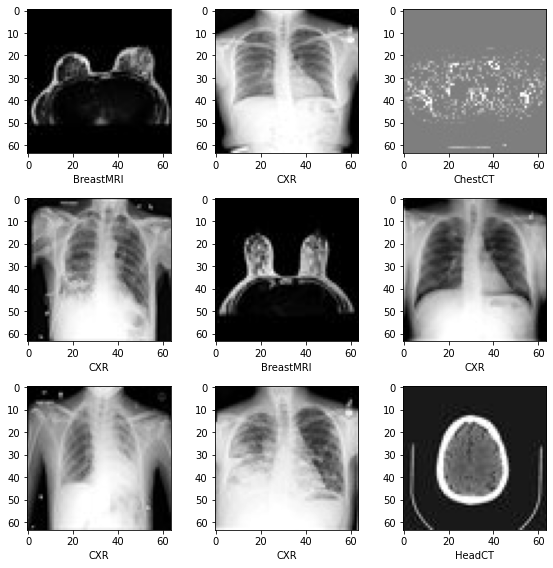

In [7]:
mp.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Take a random sample of 9 images and
    im = Image.open(imageFilesList[k])                      #      plot and label them
    arr = np.array(im)
    mp.subplot(3,3,i+1)
    mp.xlabel(classNames[imageClass[k]])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()


## Transforming Data and Partitioning into Training, Validation, and Testing Sets

Depending on the images shown, you may notice a few things. There are definitely higher and lower quality images. Also, some images also have a different scale - the background isn't black but gray. Because there's a smaller difference between pixels, our model might have a harder time extracting information from them. Thus, to increase the contrast, we first rescale every image so the pixel values run from 0 to 1. 

Next, we subtract the mean pixel value of each individual image from the rest. The network could in principle learn to do this through training. However, the activation functions tend to be most sensitive / nonlinear near zero. Therefore, shifting our data to have an average input value of zero will improve the sensitivity and stability of initial training steps and tends to speed things up a little. While it doesn't matter much for the simple model we use here, such tricks can make a noticeable difference in complex models.

Also, before doing any of these, we'll need to convert the JPEG images into tensors. We define a function below that combines all these steps.

### Code Block 4

In [8]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z


With the image-to-tensor transformation function defined, we now create a master tensor out of all these images. We also create a tensor for the labels. Execution of this code takes a moment. We double check the final range of scaled pixel values and verify that the mean is (practically) zero.

### Code Block 5

In [9]:
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))


Rescaled min pixel value = -0.786; Max = 0.972; Mean = -2.65e-09


In [10]:
imageTensor.shape

torch.Size([58954, 1, 64, 64])

With everything in order so far, we move on to partitioning these master tensors into three datatsets.

Because a model may have millions of free parameters, it is quite possible for it to <em>overfit</em> to the data provided. That is, it may adjust its weights to the precise values needed to predict every given image correctly, yet fail to recognize even slight variations on the original images, let alone brand new ones.

A common solution is to separate data into a training set, used to minimize the loss function, and a validation set, evaluated separately during training without directly affecting the model's weights. However, the validation set may be used to modify the <em>hyperparameters</em> (parameters outside the model governing its training), select the best model every epoch, or indirectly impact the training in some other way. For this reason, a third, independent testing set is usually created for final evaluation once the training is complete.

Because the more data the model sees, the more accurate it tends to become, we usually reserve relatively small fractions for validation and testing.

PyTorch has a built in <a href="https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html">Dataset</a> object that can simplify these steps when working with more complex types of data, but in this case, they would require more effort than they save.

The code below will randomly assign approximately 10% of the indices to lists corresponding to the validation and testing sets. Once this is done, we can create these datasets by slicing the master image and label tensors using these lists.

### Code Block 6

In [11]:
validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)



Training images = 47381 Validation = 5833 Testing = 5740


If we're satisfied with the breakdown into training, validation, and testing, we can now use these lists to slice the master tensors with the code below. If not, we can rerun the cell above with different fractions set aside.

### Code Block 7

In [12]:
trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]


## Model Architecture

The details of the architecture are explained in the comments within the code, but here we give an overview of the two types of layers encountered.

The first is the <em>convolutional</em> layer. When interpreting an image, the eye first identifies edges and boundaries. Then, one can make out curves, shapes, and more complex structures at higher levels of abstraction. By only combining information from nearby pixels at first, a series of convolutional layers mimics this organic process. The size of the convolution is how many adjacent pixels are weighted and added up when moving to the next layer, and we can apply multiple convolutions to every pixel in an image (or in a higher layer). Pictured below is a single 3 × 3 convolution. The value of each pixel of the convolutional kernel - these are the weights that are trained - is multiplied with the corresponding pixel value within the neighborhood of the original, central image pixel. These products are summed up, and the total is placed in the central pixel (node, to use the nomenclature) of the new layer. The process is repeated for each pixel and each convolution within the layer. Several convolutional layers can be stacked on top of each other; this has the effect of finding increasingly complex features.

<img src="images/Convolution.png" width="600" alt="Convolution">

After several convolutional layers, it is typical to have a few fully connected layers. First, all the information from the last layer is "flattened" into a vector. In a fully connected layer, there are weights connecting every single node (place to store a value) of the input layer to every single node of the output layer - no special preference is given to neighboring nodes as in the pixels of a convolutional layer. The weights multiply the values in the nodes of the input layer, are summed together, and then placed in a node of the output layer. This is repeated for each node in the output layer.

Now, there is one additional step in each of these that has been omitted: appication of the activation function. If the linear function `y = 3x + 2` is composed with `z = 4y - 7`, then z is still a linear function of x: `z = 12x + 1`. The same thing is true for linear functions in higher dimensions (multiplication by weights and summing, as we have been doing). Without the activation function, no matter how many layers we stack together, it could ultimately be replaced by a single one. To avoid this, at each output layer, we apply a nonlinear activation function. This need not be the same function at every layer. In this architecture, we choose <a href="http://image-net.org/challenges/posters/JKU_EN_RGB_Schwarz_poster.pdf">ELU</a> functions, but there are many other popular options, such as <a href="https://en.wikipedia.org/wiki/Rectifier_(neural_networks)">ReLU</a>.

### Code Block 8

In [13]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.elu(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

With the architecture defined, we create an instance of the model. This single line is separated out so that we can continue or repeat the training code below without resetting the model from scratch, if needed.

### Code Block 9

In [14]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)

## Training the Model

Now, it's time to train the model. The next code block does so.

First, we define the hyperparameters of the training. The learning rate reflects how much the model is updated per batch. If it is too small, the training proceeds slowly. If it's too large, the weights will be adjusted too much and miss the true minimum loss, or even become unstable. An epoch is a full run through the training data. Some models require thousands of epochs to train; this one will produce high accuracy with just a handful.

We use validation data to prevent overtraining in our model. The training and validation data are drawn from the same set of data; therefore, the model ought to have similar loss for both. Thus, we set a limit on how much larger the validation loss can be than the training loss. Because random fluctuation might account for some discrepancy, we require a few epochs pass with high validation loss before halting.

The memory overhead required to feed large datasets through the model can be prohibitive. <em>Batches</em> are an important workaround for this problem. By loading smaller data subsets onto the GPU and training off of them, we can not only save memory, but also speed up the training by making more adjustments to the model per epoch. Smaller batches generally require smaller learning rates to avoid instability, however, so there is some tradeoff.

Imagine that a dataset had only a handful of examples of a particular label. The model could still acheive high accuracy overall while totally ignoring these. Using weights in the loss function, with larger weights for less numerous classes, is one strategy to combat this. If a class is particularly tiny, however, it is preferable to use data augmentation to generate new images rather than using weights alone, which are equivalent to feeding the same image over and over again through the network.

Now, we move on to the actual training loop. The first real step is to shuffle the data before slicing it into batches. Once again, PyTorch provides a <a href="https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader">DataLoader</a> class that can automate this, but it's about the same difficulty in this example to implement by hand.

Next, we iterate through the batches. We zero out the accumulated information in the optimizer, feed the batch through the model, and compute the loss for a batch. We use the <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross entropy</a>, a common metric for classifiers. This loss is added to a running total for the epoch, and then we <em>backpropagate</em> it. Backpropagation is a mathematical determination of how much each weight in the model should be changed relative to the others to reduce the loss. The optimizer then takes a step and updates the weights.

After all the training batches are complete, the same process happens for the validation data, without the backpropagation and optimization steps. The average loss is calculated, and we compare the validation loss relative to the training loss to test for overfitting.

Run the cell to train the model.

### Code Block 10

In [ ]:
learnRate = 0.02          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 8           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.SGD(model.parameters(), lr = learnRate)   # Initialize an optimizer


for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break
    

Epoch =   0; Training loss = 0.0688; Validation loss = 0.0238
Epoch =   1; Training loss = 0.0151; Validation loss = 0.0169


It is most likely that training was halted early to prevent overfitting. Still, the final loss should be roughly 0.01, a huge improvement on the random guessing that the model begins with. (These are slightly dependent on how the random numbers pan out based on how many times earlier cells were executed)

You may have also noticed that the training loss is quite a bit larger than the validation loss for the first several training steps. <b>Based on what you've learned about the training process, can you explain why this happens?</b>

## Testing the Model on New Data

With the model fully trained, it's time to apply it to generate predictions from the test dataset. The model outputs a 6 element vector for each image. The individual values of this vector can be thought of, roughly, as relative probabilities that the image belongs in each class. Thus, we consider the class with the maximum value to be the prediction of the model.

We'll use these predictions to generate a confusion matrix. Despite its name, the confusion matrix is easily understood. The rows in the matrix represent the correct classifications, while the columns represent the predictions of the model. When the row and the column agree (i.e., along the diagonal), the model predicted correctly.

The short code snippet below iterates through the test batches and fills the confusion matrix.

### Code Block 11

In [27]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  5726 of 5740
Confusion Matrix:
[[968   0   0   3   1   0]
 [  0 898   0   0   0   0]
 [  0   0 991   0   1   0]
 [  0   0   0 963   0   0]
 [  0   0   1   0 938   0]
 [  8   0   0   0   0 968]]
['Hand', 'BreastMRI', 'ChestCT', 'HeadCT', 'AbdomenCT', 'CXR']


In [28]:
accurancy = correct/nTest*100
accurancy

99.7560975609756

In [29]:
error_number = nTest - correct
error_number

14

You're likely to see 99%+ accuracy. Not bad for a fairly minimal model that trains in just a couple minutes. Now look at the confusion matrix. Notice that some mistakes are more common than others - <b>does this type of confusion make sense to you?</b>

Before we get to the exercises, let's take a look at some of the images that confused the model. This cell can be rerun to produce more examples.

### Code Block 12


/var/folders/41/fr8r1hg95gl997_7cjm1cmk80000gn/T/ipykernel_6546/3837393141.py:2: UserWarning: 1MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1676448524618/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1260.)
  if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1


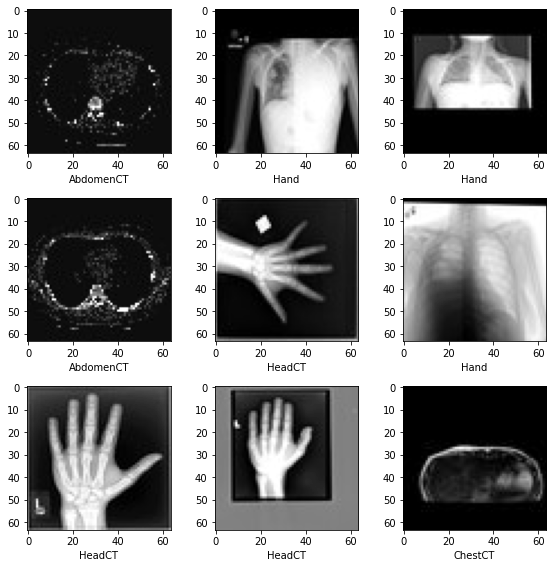

In [16]:
def scaleBack(x):               # Pass a tensor, return a numpy array from 0 to 1
    if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Remove channel (grayscale anyway)

model.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(nTest)        # Shuffle test data
testX = testX[permute,:,:,:]
testY = testY[permute]
for j in range(testBats):              # Iterate over test batches
    batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model(batX)                 # Pass test batch through model
    pred = yOut.max(1)[1].tolist()     # Generate predictions by finding the max Y values
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # Compare the actual y value to the prediction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(classNames[pred[i]])      # Label image with what the model thinks it is
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()
    
    

In [19]:
torch.save(model, 'saved_model')

Some of these images are indeed confusing, even for a human observer. Yet other other ones are harder to fathom - why did a model with 99% accuracy misclassify what is so obviously a hand, for example? The field of <a href="https://medium.com/@jrzech/what-are-radiological-deep-learning-models-actually-learning-f97a546c5b98">interpretability is beginning to explore these questions</a>.

## Exercises

It may be useful to restart the kernel (under Kernel menu) to clear the memory between exercises, or even to copy the notebook (under File menu) and do each exercise in a clean copy. Because time may be limited, scan through the exercises and start with the ones that most appeal to you. Exercises 1, 2, and 3 are particularly recommended if you are new to deep learning.

<ol>
    <li>Without resetting the kernel, increase <code>t2vRatio</code> in code block 10 and continue the training. Can you improve the final accuracy observed on the test dataset this way? If so, does it improve as much as the change in training loss would seem to indicate? What might this suggest about the relative value of architecting to training?</li><hr>
        <li>Reset the model by running code block 9, then modify the hyperparameters and retraing the model in code block 10. The most interesting ones are the learning rate (larger or smaller) and the batch size (smaller works well; when increasing the batch size, you will run out of memory somewhere in the low thousands). Note the effects on training. Can you make it converge faster than the default values?</li><hr>
    <li>Modify the architecture in code block 8 and note the effects on the training speed and final accuracy
        <ol>
            <li> Easy: Change the number of convolutions, the size of the convolutions, and the number of fully connected layers</li>
            <li> Medium: Add additional convolutional and/or fully connected layers. Use the existing code for reference.</li>
            <li> Hard: Add <a href="https://pytorch.org/docs/stable/_modules/torch/nn/modules/batchnorm.html#BatchNorm1d">batchnorm</a>, <a href="https://pytorch.org/docs/stable/_modules/torch/nn/modules/pooling.html#MaxPool2d">maxpool</a>, and/or <a href="https://pytorch.org/docs/stable/_modules/torch/nn/modules/dropout#Dropout">dropout</a> layers.</li>
        </ol>
    </li><hr>
    <li>Unbalance the classes. This is a common problem in medical imaging, and can be done by adding a single line of code in code block 2: <code>imageFiles[5] = imageFiles[5][:-NNN]</code> where <code>NNN</code> is the number images from the final class to remove. You could also replace the 5 with 0 - 4, instead. Insert this line between <code>imageFiles = ...</code> and <code>numEach = ...</code> How small of a set can you have while still getting good results for this class in the confusion matrix? This exercise combines well with the next one.</li><hr>
    <li>Remove the weights for the loss function by adding <code>CEweights = torch.ones(numClass).to(dev)</code> after the line <code>opti = ...</code> in code block 10. What effect does this have in the confusion matrix when identifying the rarer image class? You could also implement custom weights by using <code>CEweights = torch.tensor([a,b,c,d,e,f]).to(dev)</code> where <code>a ... f</code> are floating point numbers. In this case, note the effects of having one or more relatively large weights.</li><hr>
    <li>Remove one or both of the modifications to the tensor from code block 4. Note the effects on the early training and final accuracy.</li><hr>
    <li><b>Final challenge:</b>By using experience gained from the previous exercises, you can adjust the architecture and training to make a more accurate final model. Can your improved model make fewer than 10 mistakes on the testing set?</li>
</ol>



<a href="hints.txt">Hints and partial solutions to the exercises</a>